# Segmentation

## TODO

- Figure out what the problem with the exclusion loss is
- Add in the saliency hints
- Add the guided filtering for the mask

In [1]:
%pylab
%matplotlib inline

device = "mps"

Using matplotlib backend: <object object at 0x105c6a1b0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn.functional as F
from PIL import Image
import tqdm
import dipmodel
import saliency
from functools import partial

In [3]:
subplots = partial(subplots, constrained_layout=True)

## Exclusion Loss

There appears to be some issue with the exlusion loss right now. When I include it, the reconstruction loss goes up and the final reconstruction is basically just uniform black. If I take it out, the reconstruction loss goes down like it should. So I probably need to play with the exclusion loss. First make sure it is right, then see if I need to down-weight it or something. Maybe I'll look at the code for the paper.

### Original Definition

The exclusion loss is taken from the paper [Single Image Reflection Separation with Perceptrual Losses](https://arxiv.org/pdf/1806.05376.pdf). The loss is defined in section 4.3. Here are the equations as presented there:

\begin{align}
L_{\text{excl}}(\theta) & = \sum_{I\in D}\sum_{n=1}^N\|\Psi(f_T^{\downarrow n}(I;\theta), f_R^{\downarrow n}(I;\theta))\|_F \\
\Psi(T,R) & = \text{tanh}(\lambda_T|\nabla T|) \odot \text{tanh}(\lambda_R|\nabla R|) \\
\lambda_T & = \sqrt{\frac{\|\nabla R\|_F}{\|\nabla T\|_F}} \\
\lambda_R & = \sqrt{\frac{\|\nabla T\|_F}{\|\nabla R\|_F}}
\end{align}

$\lambda_T$ and $\lambda_R$ are normalization factors to account for differing gradient magnitudes between the two layers. They found the normalization to be critical. It's unclear whether it's critical for the segmentation application though.

The images $f_T$ and $f_R$ are downsampled by a factor of $2^{n-1}$ using bilinear interpolation, indicated by $f^{\downarrow n}$. $N$ was set to $3$.

The paper doesn't appear to state what operator they use to compute the image gradients $\nabla f$. They also don't say whether they use each color channel independently or convert to grayscale first.

### Double-Dip Implementation

- Replaced the norms with simple averages
- Set $\lambda_T=\lambda_R=1$
- Used a simple difference to approximate the gradient
- Replaced bilinear downsampling with strided average pool
- Changed $\Psi(T,R)$

They changed the implementation of $\Psi$ to be something like this:

\begin{align}
\Psi_v(T, R) & = \sum_{i=1}^3\sum_{j=1}^3 \left(\frac{1}{mn}\sum_{m,n}(\nabla R_i)\odot(\nabla R_i)\odot(\nabla T_j)\odot(\nabla T_j)\right)^{1/4} \\
\Psi(T,R) & = \Psi(T^x,R^x) + \Psi(T^y,R^y)
\end{align}

where $T^x$ is the $x$-gradient, for example, and $T_i$ is the $i$th color channel.

In [4]:
class SobelGradient(torch.nn.Module):
    def __init__(self):
        super().__init__()
        weights = [[1., 2, 1], [0, 0, 0], [-1, -2, -1]]
        fy = torch.tensor(weights, requires_grad=False)
        fx = torch.tensor(weights, requires_grad=False).t()
        filter = torch.stack((fx, fy), 0).view(2, 1, 3, 3)
        self.register_buffer('filter', filter)
        
    def forward(self, x):
        x = x.mean(dim=1, keepdim=True)
        g = F.conv2d(x, self.filter, padding=1).pow(2).sum(dim=1, keepdim=True).sqrt()
        return g

In [5]:
class ExclusionLoss_catalys1(torch.nn.Module):
    interp = partial(F.interpolate, align_corners=False)
    def __init__(self, n=3):
        super().__init__()
        self.sobel = SobelGradient()
        self.n = n
        
    def psi(self, x, y):
        xg = self.sobel(x)
        yg = self.sobel(y)
        
        lamx = yg.norm(dim=(2, 3)).div(xg.norm(dim=(2, 3))).sqrt()[...,None,None]
        lamy = 1 / lamx
        
        vx = xg.abs().mul(lamx).tanh()
        vy = yg.abs().mul(lamy).tanh()
        
        return vx * vy
        
    def forward(self, x1, x2):
        loss = 0
        for i in range(self.n):
            if i > 0:
                x1 = self.interp(x1, scale_factor=0.5, mode='bilinear')
                x2 = self.interp(x2, scale_factor=0.5, mode='bilinear')
            loss = loss + self.psi(x1, x2).norm(dim=(2, 3)).mean()
        return loss
    
class ExclusionLoss_Official(nn.Module):

    def __init__(self, level=3):
        """
        Loss on the gradient. based on:
        http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Single_Image_Reflection_CVPR_2018_paper.pdf
        """
        super(ExclusionLoss, self).__init__()
        self.level = level
        self.avg_pool = torch.nn.AvgPool2d(2, stride=2).type(torch.cuda.FloatTensor)
        self.sigmoid = nn.Sigmoid().type(torch.cuda.FloatTensor)

    def get_gradients(self, img1, img2):
        gradx_loss = []
        grady_loss = []

        for l in range(self.level):
            gradx1, grady1 = self.compute_gradient(img1)
            gradx2, grady2 = self.compute_gradient(img2)
            # alphax = 2.0 * torch.mean(torch.abs(gradx1)) / torch.mean(torch.abs(gradx2))
            # alphay = 2.0 * torch.mean(torch.abs(grady1)) / torch.mean(torch.abs(grady2))
            alphay = 1
            alphax = 1
            gradx1_s = (self.sigmoid(gradx1) * 2) - 1
            grady1_s = (self.sigmoid(grady1) * 2) - 1
            gradx2_s = (self.sigmoid(gradx2 * alphax) * 2) - 1
            grady2_s = (self.sigmoid(grady2 * alphay) * 2) - 1

            # gradx_loss.append(torch.mean(((gradx1_s ** 2) * (gradx2_s ** 2))) ** 0.25)
            # grady_loss.append(torch.mean(((grady1_s ** 2) * (grady2_s ** 2))) ** 0.25)
            gradx_loss += self._all_comb(gradx1_s, gradx2_s)
            grady_loss += self._all_comb(grady1_s, grady2_s)
            img1 = self.avg_pool(img1)
            img2 = self.avg_pool(img2)
        return gradx_loss, grady_loss

    def _all_comb(self, grad1_s, grad2_s):
        v = []
        for i in range(3):
            for j in range(3):
                v.append(torch.mean(((grad1_s[:, j, :, :] ** 2) * (grad2_s[:, i, :, :] ** 2))) ** 0.25)
        return v

    def forward(self, img1, img2):
        gradx_loss, grady_loss = self.get_gradients(img1, img2)
        loss_gradxy = sum(gradx_loss) / (self.level * 9) + sum(grady_loss) / (self.level * 9)
        return loss_gradxy / 2.0

    def compute_gradient(self, img):
        gradx = img[:, :, 1:, :] - img[:, :, :-1, :]
        grady = img[:, :, :, 1:] - img[:, :, :, :-1]
        return gradx, grady

In [6]:
class SegMaskRegLoss(torch.nn.Module):
    def forward(self, mask):
#         loss = 0.1 * torch.mean((1/(mask-0.5).abs()) - 2)
        loss = 1 / (mask - 0.5).abs().sum(dim=(-1, -2))
        loss = loss.mean()
        return loss

### Outline

Figure 2 in the paper shows the overall idea.
- We need 3 DIP networks: 2 for the decomposition and 1 for the mask
- Each DIP gets its own noise input
- Guided filtering is applied to learned masks (outside of optimization, I'm pretty sure)
- Image saliency can be used as initial hints to the model
- Non-constant noise is added to the noise inputs, with magnitude increasing with iterations
- The images and noise are augmented using $90^\circ$ rotations of both the vertical and horizontal flips
- Adam optimizer

In [7]:
class DoubleDipSegmentation(object):
    def __init__(self, img):
        # DoubleDip network
        dip = partial(dipmodel.dip, norm='batch')
        self.net = dipmodel.DoubleDIP(dip(), dip(), dip(c_out=1))
        # loss functions
        self.recon_loss = torch.nn.L1Loss()
#         self.excl_loss = ExclusionLoss()
        self.reg_loss = SegMaskRegLoss()
        
        self._init_data(img)
    
    def _reset_metrics(self):
        self.metrics = {'recon.loss':[],
                        'excl.loss': [],
                        'reg.loss': []}
    
    @staticmethod
    def _augmented_noise_image(h, w):
        z = torch.rand(32, h, w).to(device) * 0.1 - 0.05
        z = [z, z.flip(-1).transpose(-1,-2), z.flip((-1,-2)), z.transpose(-1,-2).flip(-1)]
        z += [x.flip(i) for x, i in zip(z, (-1, -2, -1, -2))]
        z = torch.stack(z, 0)
        z.requires_grad = False
        return z
    
    def _get_saliency(self, img):
        small = img.resize([x//2 for x in img.size], Image.BILINEAR)
        sal = saliency.hc_saliency(small)
        sal = np.asarray(Image.fromarray(sal).resize(img.size, Image.BILINEAR))
        return sal
        
    def _init_data(self, img):
        w, h = img.size
        # img + augmentations
        flip = img.transpose(0)
        imgs = ([img] + [img.transpose(i) for i in range(2, 5)] +
                [flip] + [flip.transpose(i) for i in range(2, 5)])
        imgs = torch.from_numpy(np.stack([np.asarray(x) for x in imgs], 0)).permute(0,3,1,2)
        imgs = imgs.float().div(255)
        # noise input + augmentations
        za = self._augmented_noise_image(h, w)
        zb = self._augmented_noise_image(h, w)
        zc = self._augmented_noise_image(h, w)
        # saliency-based segmentation hints
        sal = self._get_saliency(img)
        hint = Image.fromarray(255 * (sal > 0.75).astype(np.uint8))
        flip = hint.transpose(0)
        hints = ([hint] + [hint.transpose(i) for i in range(2, 5)] +
                [flip] + [flip.transpose(i) for i in range(2, 5)])
        hints = torch.from_numpy(np.stack([np.asarray(x) for x in imgs], 0))[:,None,...]
        hints = hints.float().div(255)
        
        self.imgs = imgs
        self.hints = hints
        self.za = za
        self.zb = zb
        self.zc = zc
        self.noise_map = torch.empty_like(za)
    
    def _add_noise(self, z, i, std=0.02):
#         noise = torch.normal(0.0, std * math.log10(i+1), z.shape).cuda()
        self.noise_map.normal_(0.0, max(.01, std * math.log10(i+1)))
        return z + self.noise_map
    
    def _hint_loss(self, y1, y2, m):
        n = F.l1_loss(m, torch.zeros_like(m))
        return F.l1_loss(m*y1, m*y2).div(n)
        
    def _compute_loss(self, y1, y2, m, iters):
        # We may want to add different weights to each loss. They could be on different
        # scales. Also, the gradients might be on different scales.
        mixed = m * y1 + (1 - m) * y2
        recon_loss = self.recon_loss(self.imgs, mixed)
#         excl_loss = self.excl_loss(y1, y2)
        reg_loss = self.reg_loss(m)
        total_loss = recon_loss + reg_loss# + excl_loss
        if iters < 200:
            total_loss = (total_loss + 
                          self._hint_loss(y1, y2, self.hints) +
                          self._hint_loss(y1, y2, 1-self.hints))
        
        self.metrics['recon.loss'].append(recon_loss.item())
#         self.metrics['excl.loss'].append(excl_loss.item())
        self.metrics['reg.loss'].append(reg_loss.item())
        
        return total_loss
        
    def fit(self, iters=1000, z_std=0.02, show_progress=True):
        self._reset_metrics()
        iterator = range(iters)
        if show_progress:
            iterator = tqdm.tqdm_notebook(iterator, total=iters)
            
        optim = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        inputs = (self.za, self.zb, self.zc)
#         inputs = [z.to(self.imgs.device) for z in (self.za, self.zb, self.zc)]
#         self.noise_map.
        
        for i in iterator:
            za, zb, zc = (self._add_noise(z, i, z_std).to(self.imgs.device)
                          for z in inputs)
            y1, y2, m = self.net(za, zb, zc)
            loss = self._compute_loss(y1, y2, m, i)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if show_progress:
                iterator.set_postfix_str(str(loss.item()))
    
    @torch.no_grad()
    def reconstruct(self):
        y1, y2, m = self.net(self.za, self.zb, self.zc)
        res = m * y1 + (1 - m) * y2
        return res
    
    @torch.no_grad()
    def layers(self):
        y1, y2, m = self.net(self.za, self.zb, self.zc)
        return y1, y2, m
    
    def tocuda(self):
        self.net = self.net.to(device)
        self.imgs = self.imgs.to(device)
        self.hints = self.hints.to(device)
#         self.za = self.za.cuda()
#         self.zb = self.zb.cuda()
#         self.zc = self.zc.cuda()
#         self.excl_loss = self.excl_loss.cuda()
        return self

In [8]:
# inputs = (segmenter.za, segmenter.zb, segmenter.zc)
# za, zb, zc = (segmenter._add_noise(z, 10, .02).to(segmenter.imgs.device) for z in inputs)
# y1, y2, m = self.net(za, zb, zc)

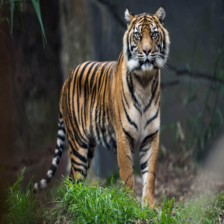

In [9]:
img = Image.open('images/tiger.jpg').convert('RGB').resize((224,224), Image.BILINEAR)
img

In [10]:
segmenter = DoubleDipSegmentation(img).tocuda()

In [11]:
segmenter.fit(2000)

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_43275/2379657898.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm.tqdm_notebook(iterator, total=iters)


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [12]:
del segmenter
torch.cuda.empty_cache()
import gc
gc.collect()

1399

In [13]:
res = segmenter.reconstruct()
with torch.no_grad():
    y1, y2, m = segmenter.net(segmenter.za, segmenter.zb, segmenter.zc)

NameError: name 'segmenter' is not defined

NameError: name 'res' is not defined

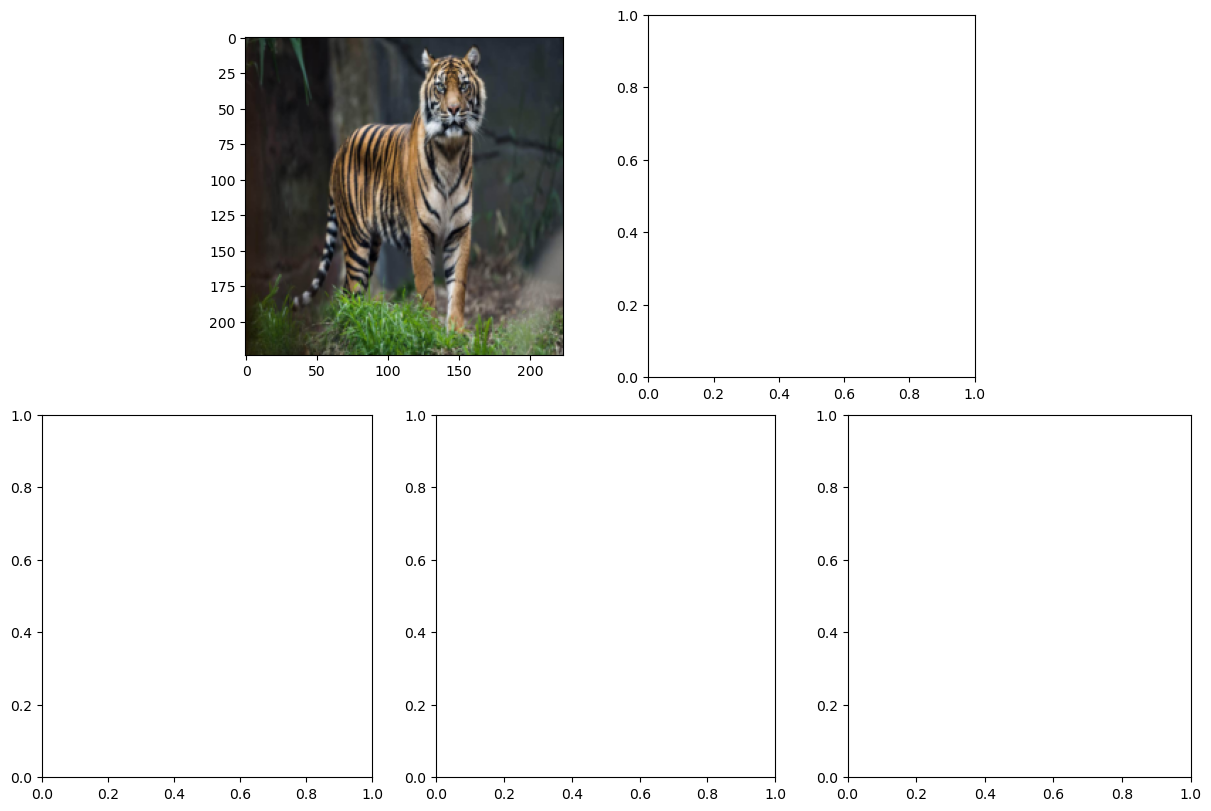

In [14]:
def todisp(x):
    return x.permute(1,2,0).cpu().squeeze()

def axisoff(ax):
    for a in ax: a.axis('off')

# fig, ax = subplots(1, 4, figsize=(12, 3.5), constrained_layout=True)
fig = figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(ncols=6, nrows=2)
ax = [fig.add_subplot(gs[i, j:j+2]) for i,j in zip([0,0,1,1,1],[1,3,0,2,4])]
ax[0].imshow(img)
ax[1].imshow(todisp(res[0]))
ax[2].imshow(todisp(y1[0]))
ax[3].imshow(todisp(y2[0]))
ax[4].imshow(todisp(m[0]), cmap='gray')
axisoff(ax)

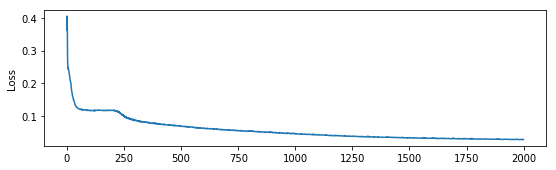

In [ ]:
figure(figsize=(9, 2.5))
plot(segmenter.metrics['recon.loss'])
ylabel('Loss')
savefig('/home/catalys1/Downloads/tiger-recon-loss.pdf')
# plot(segmenter.metrics['reg.loss'])

In [ ]:
((1/(m[0].detach()-0.5).abs())-2).mean() / 10

tensor(0.1290, device='cuda:0')